In [1]:
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import piqa
import utils
from models import UNet

### Load data

In [2]:
img = utils.load_image('data/set5/butterfly.png')
noisy_img = utils.get_noisy_image(img, 0.1)

### Denoise

In [3]:
epochs = 1800
lr = 0.01
input_channels = 3

In [4]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

net = UNet(input_channels)
net.to(device)

optimizer = optim.Adam(net.parameters(), lr)
mse = nn.MSELoss()

noisy_img = noisy_img.to(device)

input_shape = [input_channels if i == 1 else s for i, s in enumerate(noisy_img.size())]
z = torch.rand(input_shape, device=device) * 0.1  # TODO regularize noise?

Training on cuda:0
----------
Epoch  100/1800 | Loss: 0.02770714834332466
Epoch  200/1800 | Loss: 0.01730761118233204
Epoch  300/1800 | Loss: 0.014381783083081245
Epoch  400/1800 | Loss: 0.013474437408149242
Epoch  500/1800 | Loss: 0.012406891211867332
Epoch  600/1800 | Loss: 0.012339772656559944
Epoch  700/1800 | Loss: 0.011681756004691124
Epoch  800/1800 | Loss: 0.011391091160476208
Epoch  900/1800 | Loss: 0.011049866676330566
Epoch 1000/1800 | Loss: 0.011263098567724228
Epoch 1100/1800 | Loss: 0.010940179228782654
Epoch 1200/1800 | Loss: 0.010716951452195644
Epoch 1300/1800 | Loss: 0.010694071650505066
Epoch 1400/1800 | Loss: 0.011160201393067837
Epoch 1500/1800 | Loss: 0.01058157067745924
Epoch 1600/1800 | Loss: 0.010415598750114441
Epoch 1700/1800 | Loss: 0.010429381392896175
Epoch 1800/1800 | Loss: 0.010314210318028927
----------
Finished training in 00:00:57


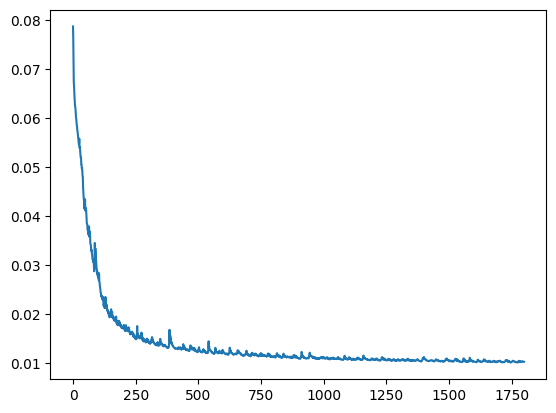

In [5]:
net.train()

print(f'Training on {device}')
print('----------')
start = time.time()

losses = []
for i in range(epochs):
  optimizer.zero_grad()

  out = net(z)
  loss = mse(out, noisy_img)
  loss.backward()
  optimizer.step()

  losses.append(loss.item())

  if i % 100 == 99:
    print(f'Epoch {i + 1:4d}/{epochs} | Loss: {loss.item()}')

duration = time.time() - start
print('----------')
print(f'Finished training in {time.strftime('%H:%M:%S', time.gmtime(duration))}')

plt.plot(losses)
plt.show()

In [6]:
denoised_img = net(z)

denoised_img = denoised_img.detach().cpu()
noisy_img = noisy_img.cpu()

### Evaluate

In [7]:
psnr = piqa.PSNR()
noisy_psnr = psnr(noisy_img, img).item()
denoised_psnr = psnr(denoised_img, img).item()

print('PSNR (↑)')
print('----------')
print(f'Noisy: {noisy_psnr}')
print(f'Denoised: {denoised_psnr}')

PSNR (↑)
----------
Noisy: 20.291580200195312
Denoised: 27.414758682250977


In [8]:
ssim = piqa.SSIM()
noisy_ssim = ssim(noisy_img, img).item()
denoised_ssim = ssim(denoised_img, img).item()

print('SSIM (↑)')
print('----------')
print(f'Noisy: {noisy_ssim}')
print(f'Denoised: {denoised_ssim}')

SSIM (↑)
----------
Noisy: 0.518828809261322
Denoised: 0.8844552040100098


### Visualize

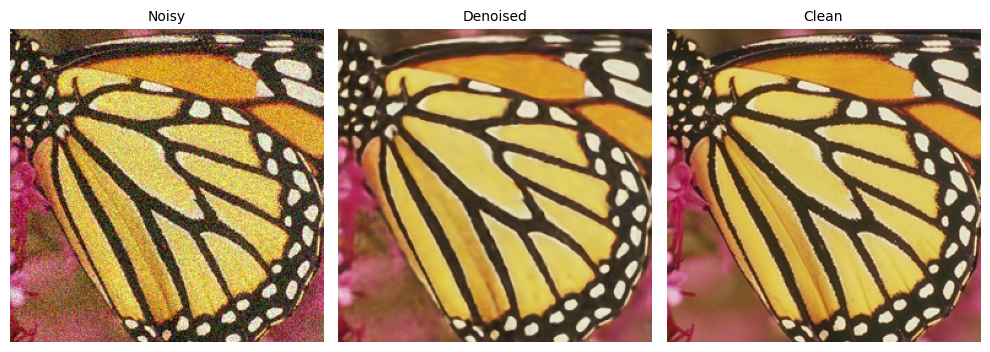

In [9]:
utils.plot_row([noisy_img, denoised_img, img], ['Noisy', 'Denoised', 'Clean'])